/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


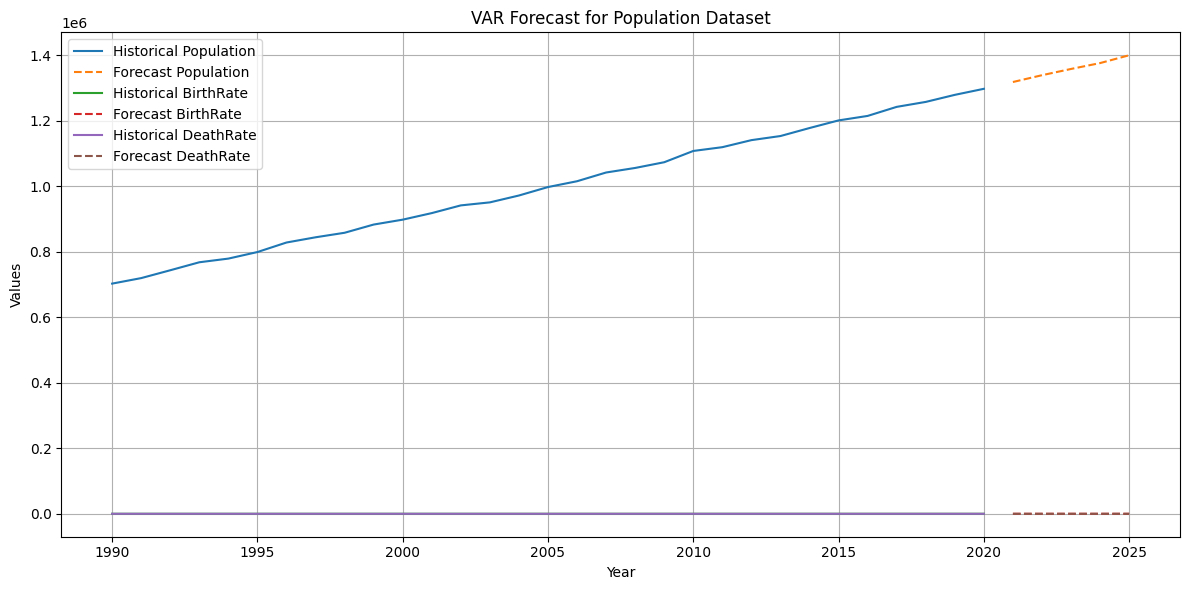


Forecasted Data (2021–2025):
        Population  BirthRate  DeathRate
2021  1.317745e+06  17.584828   8.019678
2022  1.338503e+06  17.358314   7.673597
2023  1.357579e+06  16.797011   7.666017
2024  1.375533e+06  16.471799   7.547135
2025  1.399382e+06  16.010954   7.338258


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller

# Step 1: Simulate multivariate population dataset with variability
years = np.arange(1990, 2021)
np.random.seed(42)

population = np.linspace(700000, 1300000, len(years)) + np.random.normal(0, 5000, len(years))
birth_rate = np.linspace(30, 18, len(years)) + np.random.normal(0, 0.3, len(years))
death_rate = np.linspace(12, 8, len(years)) + np.random.normal(0, 0.2, len(years))

df = pd.DataFrame({
    'Year': years,
    'Population': population,
    'BirthRate': birth_rate,
    'DeathRate': death_rate
})
df.set_index('Year', inplace=True)

# Step 2: Make data stationary (Differencing)
def make_stationary(data):
    df_diff = data.copy()
    for col in df_diff.columns:
        result = adfuller(df_diff[col])
        if result[1] > 0.05:  # Not stationary
            df_diff[col] = df_diff[col].diff()
    return df_diff.dropna()

df_stationary = make_stationary(df)

# Step 3: Fit VAR model
model = VAR(df_stationary)
results = model.fit(maxlags=4, ic='aic')

# Step 4: Forecast next 5 years
forecast_steps = 5
forecast_input = df_stationary.values[-results.k_ar:]
forecast = results.forecast(y=forecast_input, steps=forecast_steps)

# Step 5: Prepare forecast DataFrame
forecast_index = np.arange(df.index[-1] + 1, df.index[-1] + 1 + forecast_steps)
forecast_df = pd.DataFrame(forecast, index=forecast_index, columns=df.columns)

# Step 6: Revert differencing
last_values = df.iloc[-1]
forecast_df_cumsum = forecast_df.cumsum()
forecast_df_final = forecast_df_cumsum.add(last_values)

# Step 7: Plot historical and forecast data
plt.figure(figsize=(12, 6))
for col in df.columns:
    plt.plot(df[col], label=f'Historical {col}')
    plt.plot(forecast_df_final[col], '--', label=f'Forecast {col}')

plt.title("VAR Forecast for Population Dataset")
plt.xlabel("Year")
plt.ylabel("Values")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Step 8: Display forecasted values
print("\nForecasted Data (2021–2025):")
print(forecast_df_final)